## Image classification with Convolutional Neural Networks

In [59]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [60]:
# This file contains all the main external libs we'll use
from fastai.imports import *
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

## Astronauts vs Aliens

In [61]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

* `PATH` is the path to the data

* `sz` is the size that the images will be resized to be this is a very important value

In [62]:
PATH = "data/astronautsaliens/"
sz=300

NVidia GPU is currently necessary, I'm using Paperspace currently for this GPU curruntly a M4000 51 c/hr. The framework behind NVidia GPU's is CUDA basically a standard for machine learning backends. The following should return true.

In [63]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return True, you may want to look into why.

In [64]:
torch.backends.cudnn.enabled

True

### Data Set

Make sure its available in the same directory as this notebook.

## First look at cat pictures

The library will assume that you have train and valid directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'aliens' and 'astronauts').

In [65]:
# This lists what is under the PATH we set earlier
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp']

In [66]:
# These directories are in the valid dir
# replace valid with train you'll notice the same thing
os.listdir(f'{PATH}valid')

['aliens', 'astronauts']

In [109]:
# Grab 5 astronaut files
# Below is a Python 3.6 format string
files = os.listdir(f'{PATH}valid/astronauts')[:5]
files

['astro.104.jpg',
 'astro.158.jpg',
 'astro20.jpg',
 'astro.162.jpg',
 'astro.164.jpg']

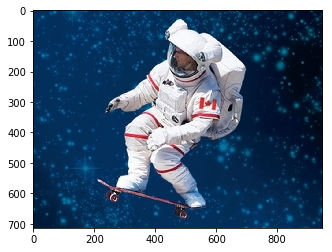

In [111]:
# This is astronaut #5
# A Canadian astronaut
img = plt.imread(f'{PATH}valid/astronauts/{files[2]}')
plt.imshow(img);

Here is what the raw data looks like

In [112]:
# rank 3 tensor pixel height width and rgb
# height 798
# width 1074
# rgb per pixel 3
img.shape

(713, 948, 3)

In [113]:
# rgb values first four rows and columns
img[:4,:4]

array([[[ 1, 49, 97],
        [ 1, 49, 98],
        [ 1, 49, 98],
        [ 1, 47, 96]],

       [[ 1, 49, 97],
        [ 1, 49, 97],
        [ 0, 48, 96],
        [ 0, 48, 96]],

       [[ 1, 49, 97],
        [ 0, 48, 96],
        [ 0, 48, 96],
        [ 0, 48, 96]],

       [[ 0, 48, 96],
        [ 0, 48, 96],
        [ 0, 48, 96],
        [ 1, 48, 94]]], dtype=uint8)

## Train the model: quick start

We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

In [114]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

### Super high level Training using fast.ai libraries

In [115]:
# This may take awhile the first time it runs
# This is due to the pretrained model needing to be downloaded
# We're doing 3 epochs with a step size of 0.01
# An epoch is a full pass through all the images
# The table below tells you what the numbers mean 
# Loss train | loss valid | Accuracy
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
print(PATH)
learn.fit(0.01, 3)

data/astronautsaliens/


epoch      trn_loss   val_loss   accuracy   
    0      0.724715   0.380655   0.839506  
    1      0.45665    0.165144   0.938272  
    2      0.332213   0.101609   0.962963  



[array([0.10161]), 0.9629629629629629]

80% accuracy used to be state of the art

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

### Objects data & learn

data will hold all of our data contains:
* validation data
* training data

learn will hold the model

In [116]:
# This is the label for a val data
# 0's for cats 1's for dogs
# validation dependent variable: y
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [117]:
# from here we know that 'aliens' is label 0 and 'astronauts' is label 1.
data.classes

['aliens', 'astronauts']

In [118]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(81, 2)

In [119]:
# First 10 predictions
# most models return the log of the prediction rather than the probabilities
# labels |astronaut|alien|
# to get probabilities use e^x
log_preds[:10]

array([[-0.00195, -6.23914],
       [-0.00376, -5.5839 ],
       [-0.19941, -1.71046],
       [-0.00895, -4.72062],
       [-0.39122, -1.12772],
       [-2.15205, -0.12358],
       [-0.03204, -3.45664],
       [-1.95103, -0.1533 ],
       [-0.59351, -0.80383],
       [-0.08724, -2.48239]], dtype=float32)

In [120]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(astronaut)

In [121]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)

In [122]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [123]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


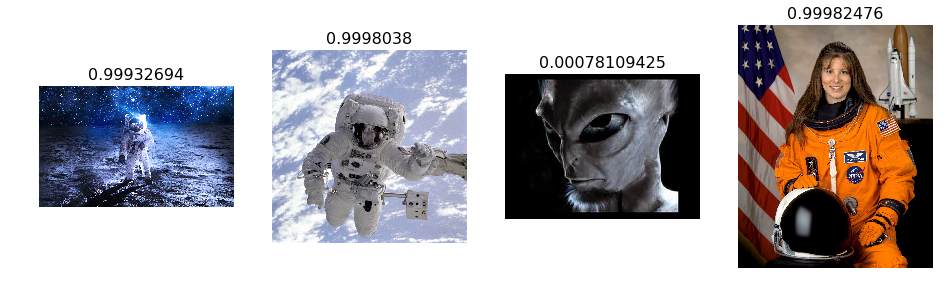

In [124]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [125]:
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [126]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct aliens


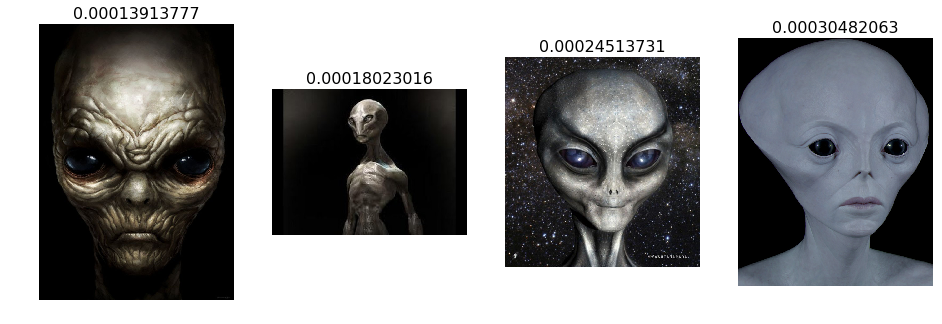

In [127]:
plot_val_with_title(most_by_correct(0, True), "Most correct aliens")

Most correct astronauts


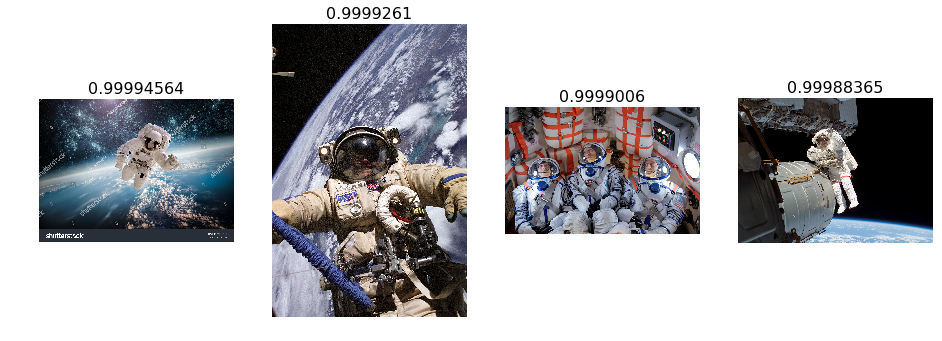

In [128]:
plot_val_with_title(most_by_correct(1, True), "Most correct astronauts")

Most incorrect aliens


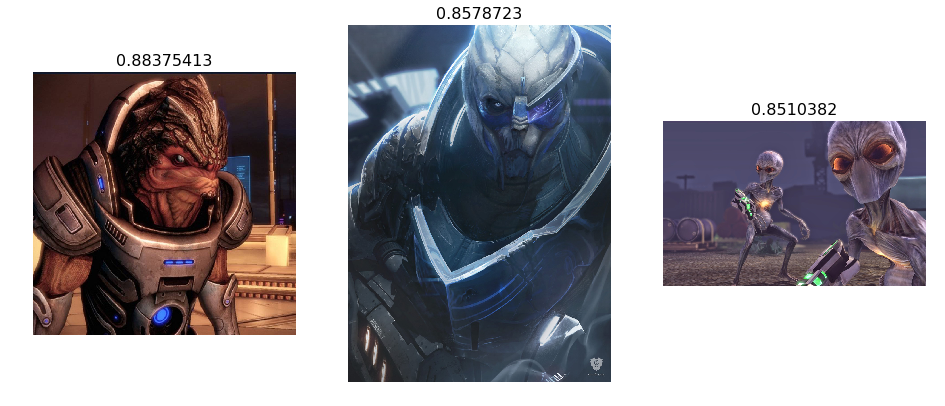

In [129]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect aliens")

In [131]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect astronauts") # empty

Most incorrect astronauts


<Figure size 1152x576 with 0 Axes>

Most uncertain predictions


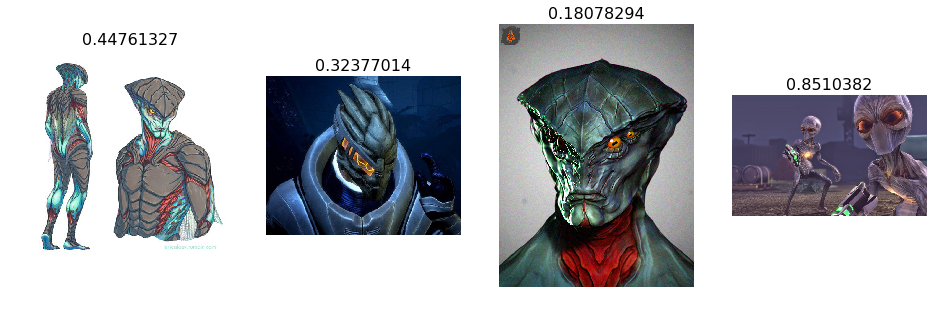

In [132]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [133]:
# redefine learn object
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [134]:
# Learning rate finder
# start at very small learning rates and gradually increase
# you can see this behavior in the graph below
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy   
    0      0.617516   0.265483   0.938272  



Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

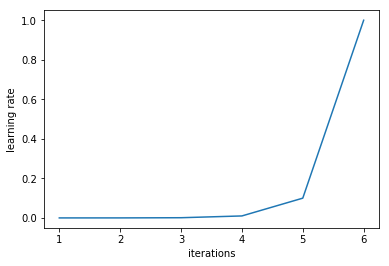

In [138]:
# exponential growth is used to increase learning rate
learn.sched.plot_lr()

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

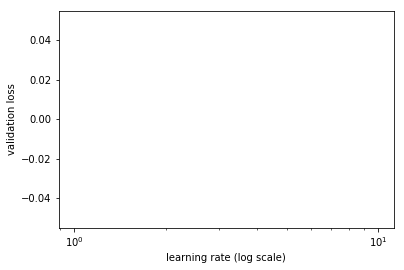

In [139]:
# helps choose this particular hyper parameter
# not enough data for useful info
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

## Improving our model


### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [140]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [141]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [142]:
ims = np.stack([get_augs() for i in range(10)])

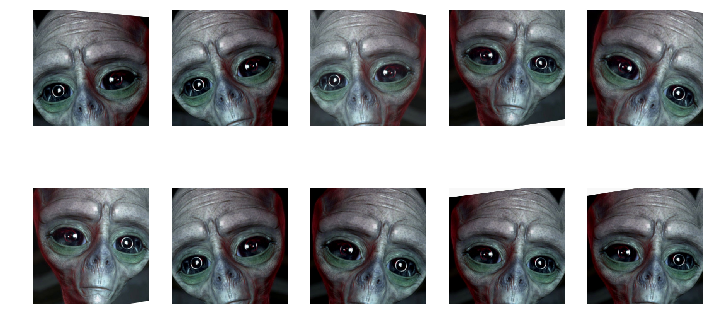

In [143]:
plots(ims, rows=2)

(300, 300, 3)

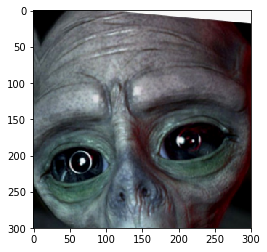

In [147]:
# every image is 300 x 300 now
# this may pose a problem for long or tall images
# key features may be cut out
# this is why use data augmentation
plt.imshow(ims[0]);
ims[0].shape

Let's create a new `data` object that includes this augmentation in the transforms.

In [148]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
# pre compute is still equal to true
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [151]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                
    0      0.255571   0.173275   0.950617  
    1      0.200653   0.081034   0.975309                
    2      0.162403   0.04717    1.0                     



[array([0.04717]), 1.0]

In [152]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [153]:
# If you're doing much better on the training set than
# the validation set, that means your model is not generalizing
# We are not at that point here but we also are not improving
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      0.092104   0.043915   1.0       
    1      0.087208   0.039949   1.0                      
    2      0.079097   0.036756   1.0                      



[array([0.03676]), 1.0]

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

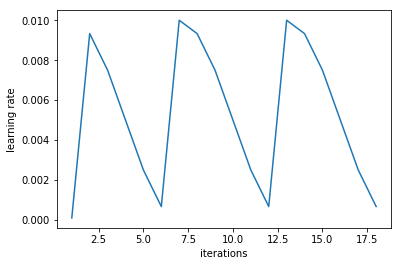

In [154]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [155]:
learn.save('300_lastlayer')

In [156]:
learn.load('300_lastlayer')

### Fine-tuning and differential learning rate annealing


Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [157]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [158]:
# Resnet, we are grouping layers into 3 groups
# smaller learning rates for early layers for fine tuning
# probably dont even need or want to train them
# it will use a different learning rate for each layer
lr=np.array([1e-4,1e-3,1e-2])

In [159]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.103571   0.034915   1.0       
    1      0.114485   0.027727   1.0                     
    2      0.101437   0.028871   1.0                     
    3      0.089697   0.018095   1.0                      
    4      0.081556   0.015646   1.0                      
    5      0.07474    0.01461    1.0                      
    6      0.072693   0.014431   1.0                      



[array([0.01443]), 1.0]